In [57]:
required_packages <- c("plgp", "lhs", "mvtnorm", "laGP", "hetGP")
install.packages(setdiff(required_packages, rownames(installed.packages())))

In [58]:
library(plgp)

### 6.1.1 Maximum entropy design

In [59]:
maxent <- function(n, m, theta=0.1, g=0.01, T=100000) 
 {  
  if(length(theta) == 1) theta <- rep(theta, m)
  X <- matrix(runif(n*m), ncol=m)
  K <- covar.sep(X, d=theta, g=g) 
  ldetK <- determinant(K, logarithm=TRUE)$modulus

  for(t in 1:T) {
    row <- sample(1:n, 1)
    xold <- X[row,] 
    X[row,] <- runif(m)
    Kprime <- covar.sep(X, d=theta, g=g)
    ldetKprime <- determinant(Kprime, logarithm=TRUE)$modulus
    if(ldetKprime > ldetK) { ldetK <- ldetKprime  
    } else { X[row,] <- xold }
  }
  return(X)
}

In [60]:
X <- maxent(25, 2)
X

0.2630181126,0.002549052
0.2386616757,0.760565347
0.7692174001,0.001266867
0.6462407715,0.593603995
0.2003040740,0.998876202
0.4494231918,0.997548179
0.5364917680,0.818478057
0.0083908206,0.009061313
0.0048975500,0.734246869
0.9933637665,0.011454114
0.9956506155,0.576675044


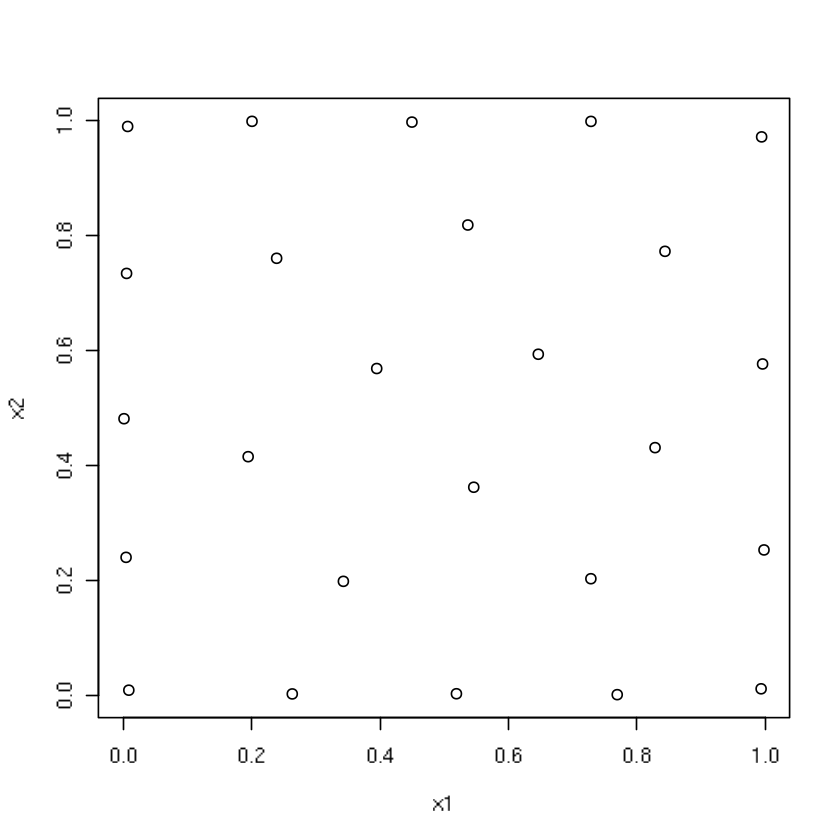

In [61]:
plot(X, xlab="x1", ylab="x2")

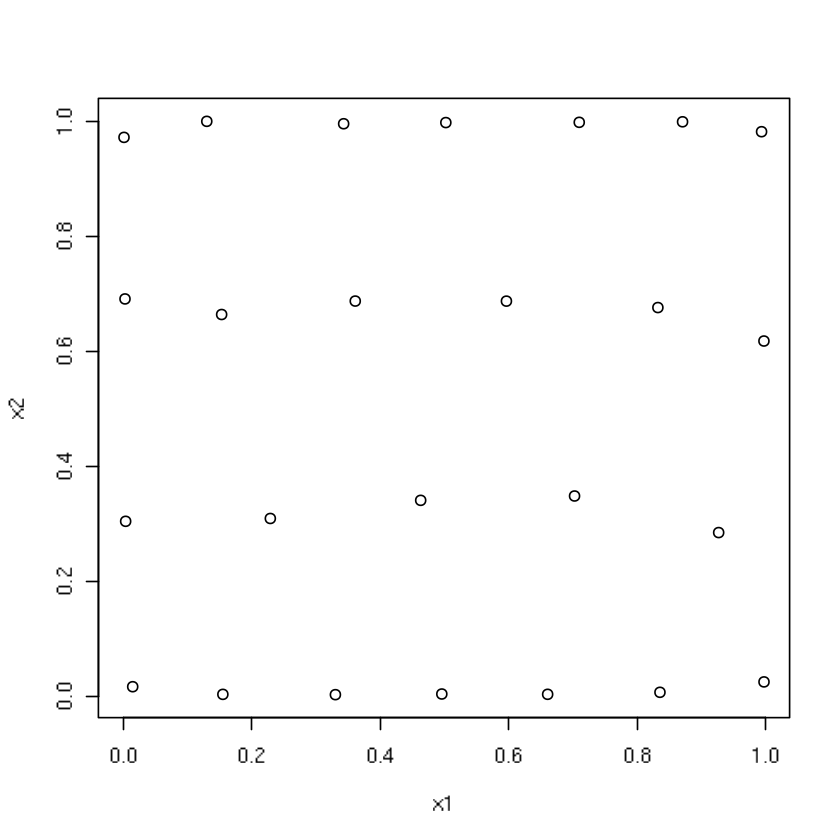

In [62]:
X <- maxent(25, 2, theta=c(0.1, 0.5))
plot(X, xlab="x1", ylab="x2")

In [63]:
X <- maxent(25, 3)

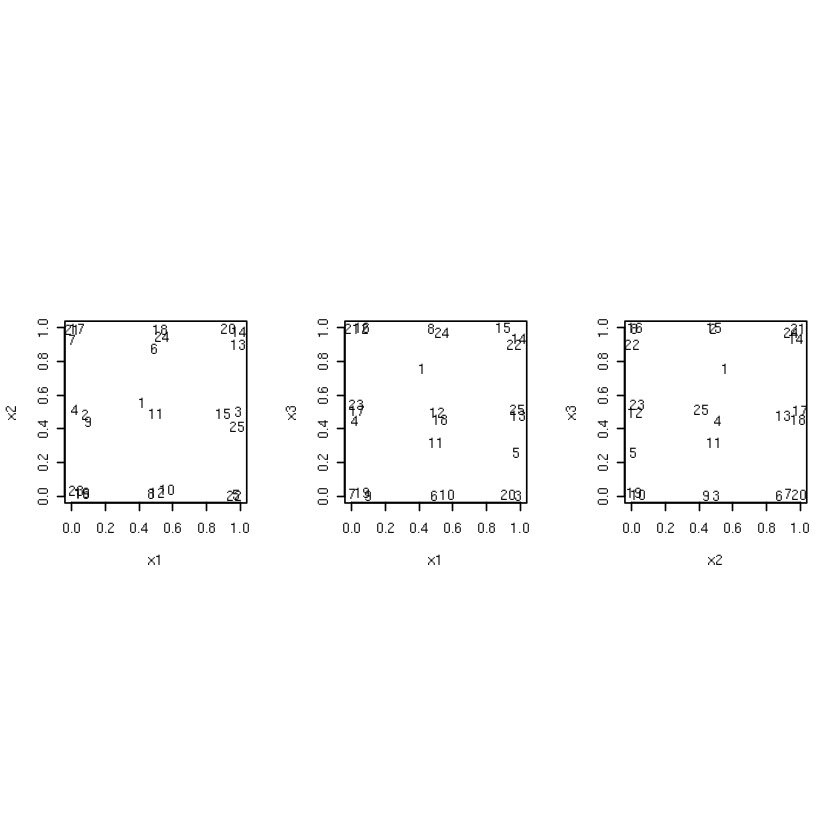

In [64]:
Is <- as.list(as.data.frame(combn(ncol(X),2)))
par(mfrow=c(1,length(Is)), pty="s")
for(i in Is) {
  plot(X[,i], xlim=c(0,1), ylim=c(0,1), type="n",
    xlab=paste0("x", i[1]), ylab=paste0("x", i[2]))
  text(X[,i], labels=1:nrow(X)) 
}

### 6.1.2 Minimizing predictive uncertainty

In [65]:
library(hetGP)
imspe.criteria <- function(X, theta, g, ...) 
 {
  IMSPE(X, theta=theta, Lambda=diag(g, nrow(X)), covtype="Gaussian",
    mult=rep(1, nrow(X)), nu=1) 
 }

In [66]:
imspe <- function(n, m, theta=0.1, g=0.01, T=100000, ...) 
 {  
  if(length(theta) == 1) theta <- rep(theta, m)
  X <- matrix(runif(n*m), ncol=m)
  I <- imspe.criteria(X, theta, g, ...)

  for(t in 1:T) {
    row <- sample(1:n, 1)
    xold <- X[row,] 
    X[row,] <- runif(m)
    Iprime <- imspe.criteria(X, theta, g, ...)
    if(Iprime < I) { I <- Iprime 
    } else { X[row,] <- xold }
  }
  return(X)
}

In [67]:
options(warn=-1)
X <- imspe(25, 2)

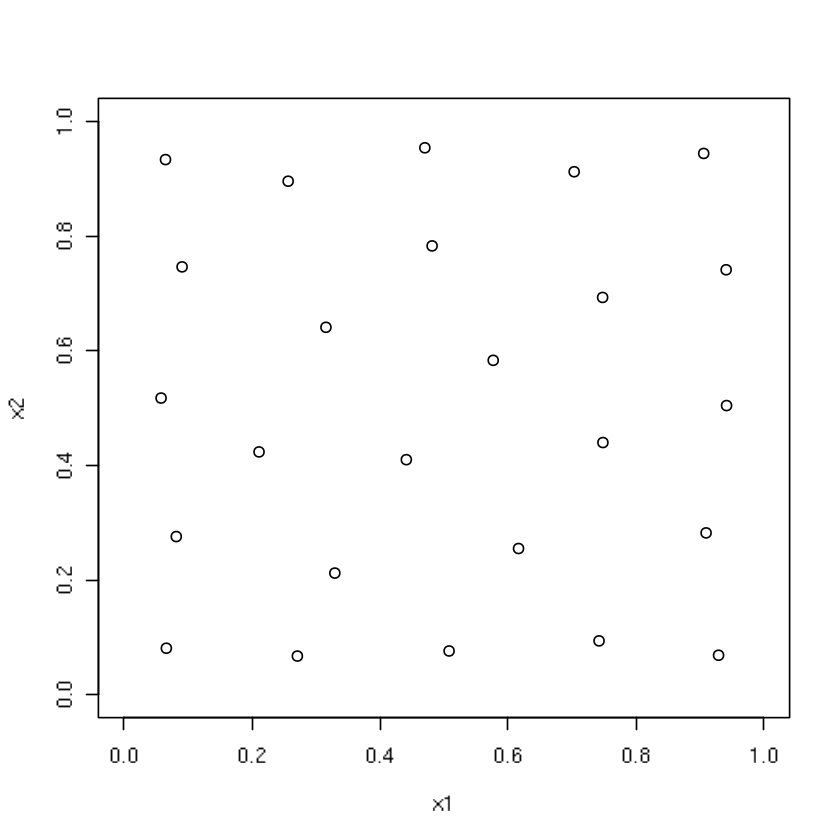

In [68]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))

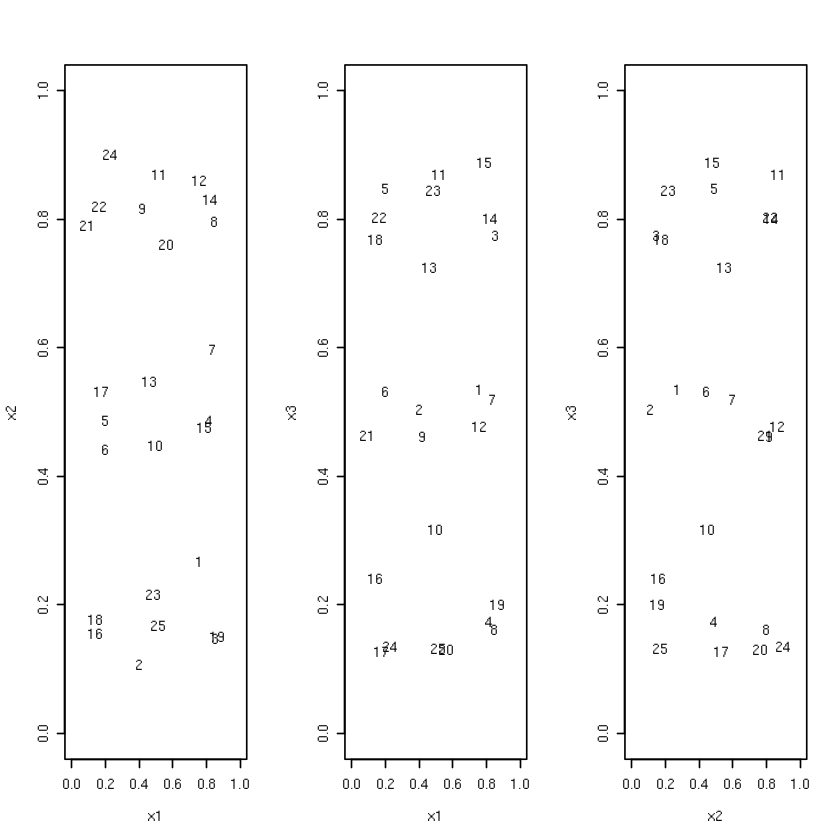

In [70]:
X <- imspe(25, 3)

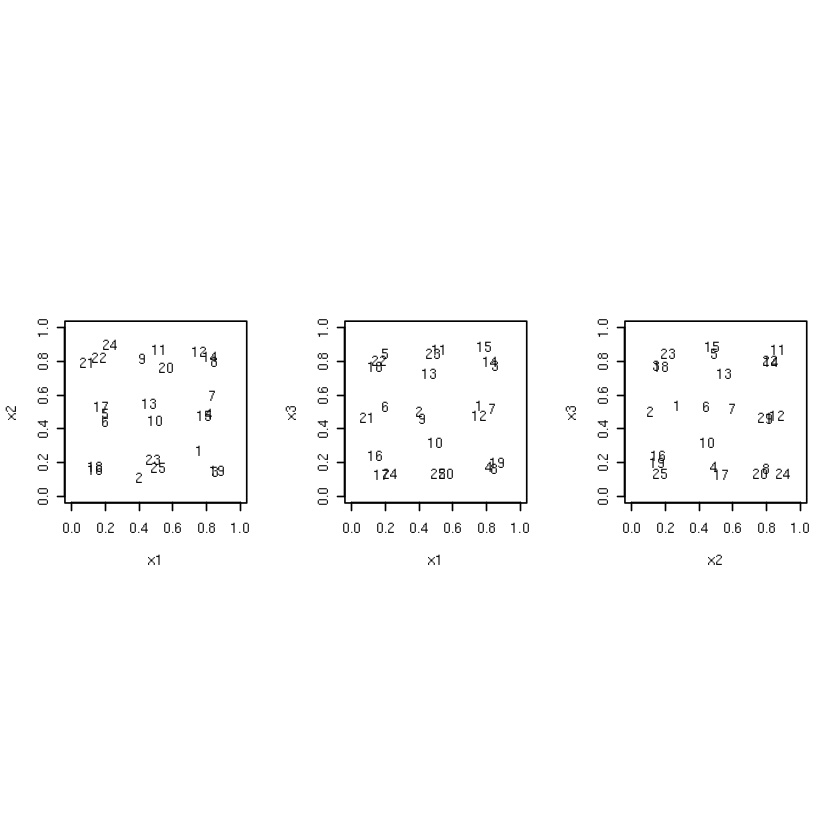

In [71]:
Is <- as.list(as.data.frame(combn(ncol(X),2)))
par(mfrow=c(1,length(Is)), pty="s")
for(i in Is) {
  plot(X[,i], xlim=c(0,1), ylim=c(0,1), type="n",
    xlab=paste0("x", i[1]), ylab=paste0("x", i[2]))
  text(X[,i], labels=1:nrow(X)) 
}

In [72]:
imspe.criteria <- function(X, theta, g, Xref) {
  K <- covar.sep(X, d=theta, g=g)
  Ki <- solve(K)
  KXref <- covar.sep(X, Xref, d=theta, g=0)
  return(mean(1 + g - diag(t(KXref) %*% Ki %*% KXref)))
}

In [73]:
g <- expand.grid(seq(0,1,length=10), seq(0,1,length=10))
X <- imspe(25, 2, Xref=g)

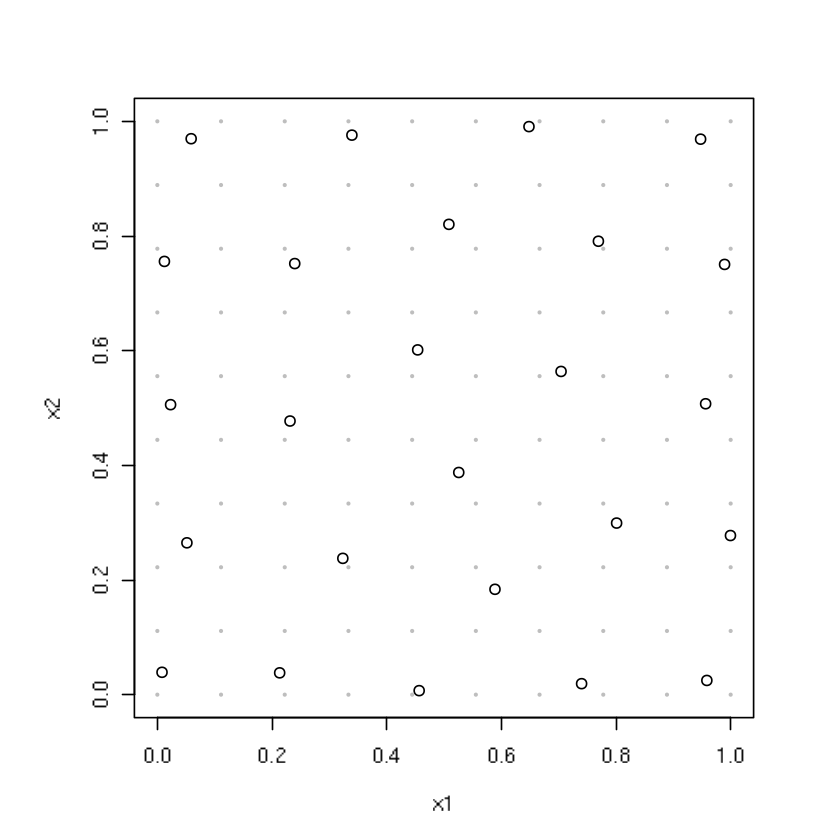

In [77]:
par(pty="s")
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
points(g, pch=20, cex=0.25, col="gray")

In [81]:
Xref <- rmvnorm(100, mean=c(0.25, 0.25),
       sigma=0.005*rbind(c(2, 0.35), c(0.35, 0.1)))
Xref <- rbind(Xref, rmvnorm(100, mean=c(0.25, 0.25),
       sigma=0.005*rbind(c(0.1, -0.35), c(-0.35, 2))))
X <- imspe(25, 2, Xref=Xref)

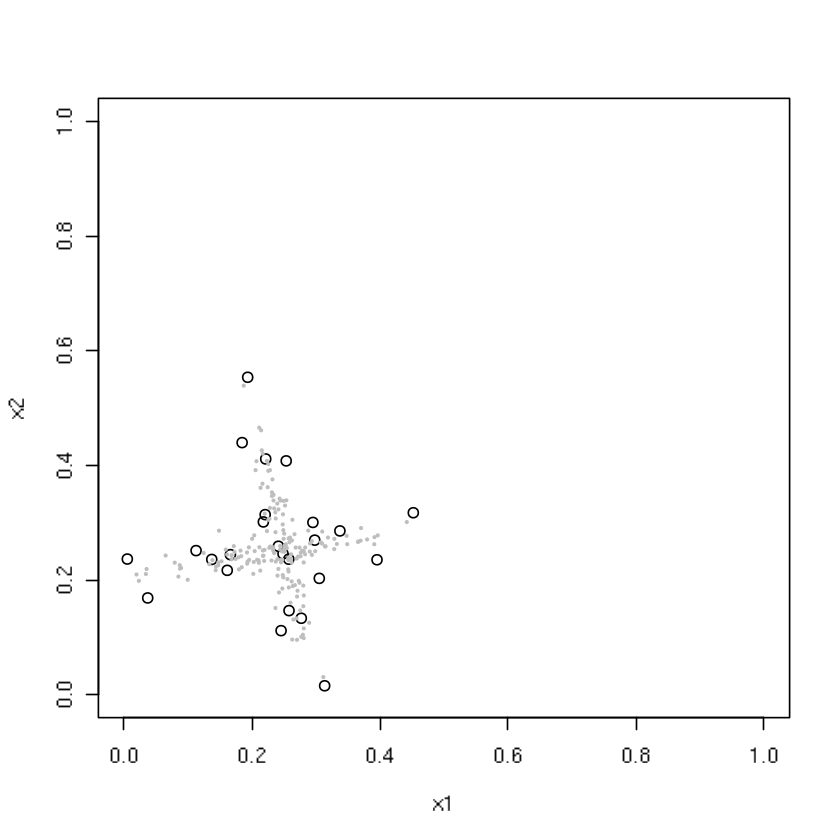

In [83]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
points(Xref, pch=20, cex=0.25, col="gray")

### 6.2.1 Whack-a-mole: active learning MacKay

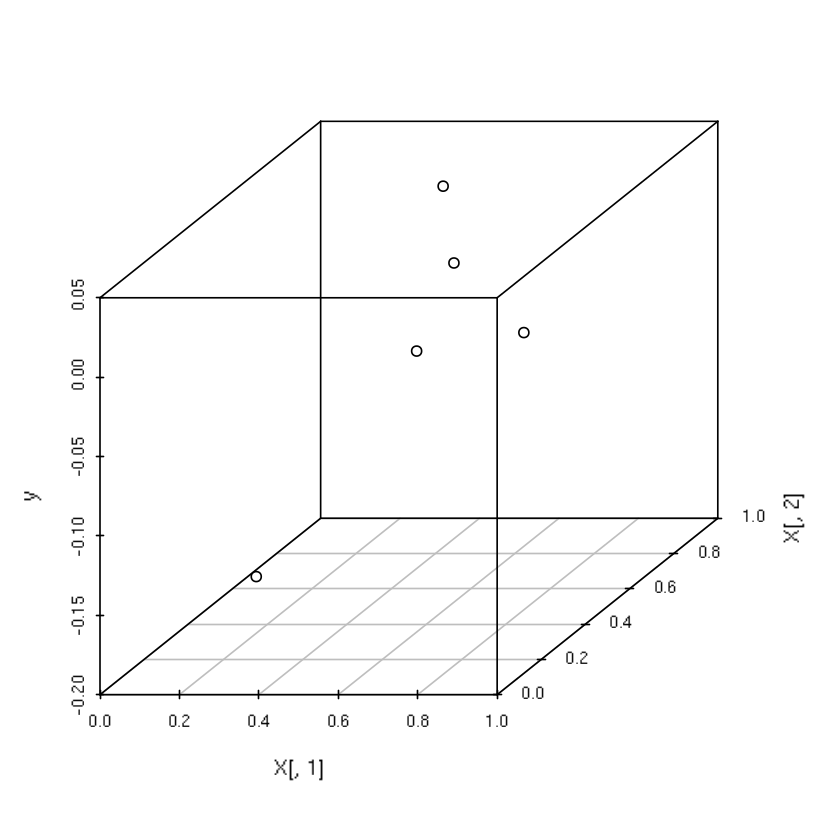

In [203]:
library(lhs)
ninit <- 12
X <- randomLHS(ninit, 2)

f <- function(X, sd=0.01) {
  X[,1] <- (X[,1] - 0.5)*6 + 1
  X[,2] <- (X[,2] - 0.5)*6 + 1
  y <- X[,1] * exp(-X[,1]^2 - X[,2]^2) + rnorm(nrow(X), sd=sd)
}

y <- f(X)

library(scatterplot3d)
scatterplot3d(x = X[,1], y = X[,2], z = y)

In [204]:
library(laGP)
g <- garg(list(mle=TRUE, max=1), y)
d <- darg(list(mle=TRUE, max=0.25), X)
gpi <- newGP(X, y, d=d$start, g= g$start, dK=TRUE)
mle <- jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), d$ab, g$ab)

In [205]:
x1 <- x2 <- seq(0, 1, length=100)
XX <- expand.grid(x1, x2)
yytrue <- f(XX, sd=0.0)

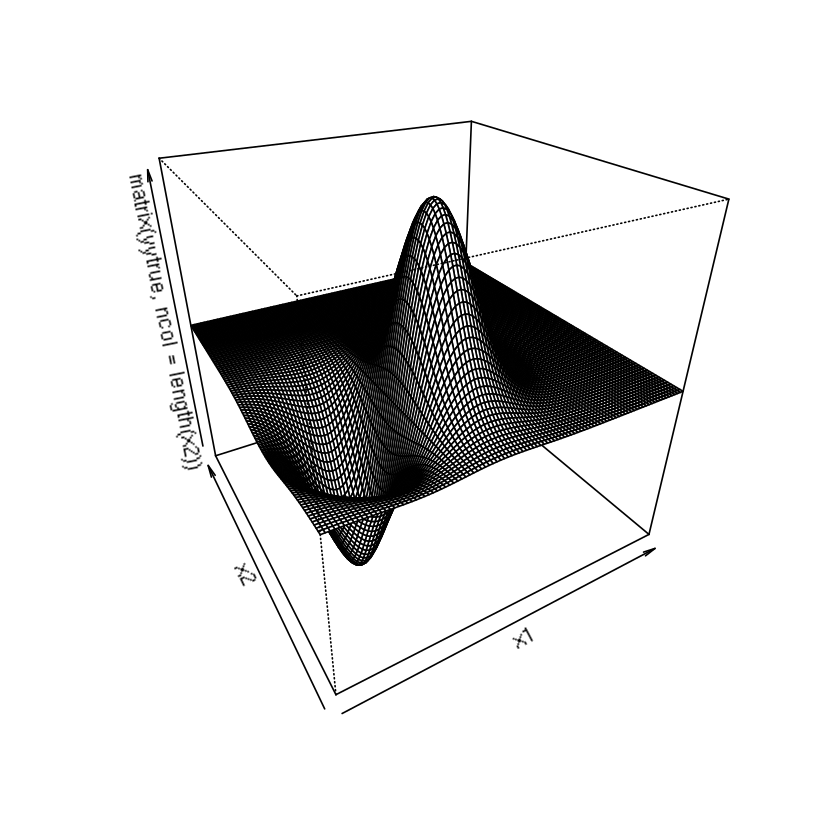

In [206]:
persp(x=x1, y=x2, z=matrix(yytrue, ncol=length(x2)), theta=-30, phi=30)

In [207]:
rmse <- sqrt(mean((yytrue - predGP(gpi, XX, lite=TRUE)$mean)^2))
rmse

[1] 0.1030297

In [208]:
obj.alm <- function(x, gpi) 
  - sqrt(predGP(gpi, matrix(x, nrow=1), lite=TRUE)$s2)

In [209]:
## from 4.2.1 copied-pasted
mymaximin <- function(n, m, T=100000, Xorig=NULL) 
 {   
  X <- matrix(runif(n*m), ncol=m)     ## initial design
  d <- distance(X)
  d <- d[upper.tri(d)]
  md <- min(d)
  if(!is.null(Xorig)) {               ## new code
    md2 <- min(distance(X, Xorig))
    if(md2 < md) md <- md2
  }

  for(t in 1:T) {
    row <- sample(1:n, 1)
    xold <- X[row,]                   ## random row selection
    X[row,] <- runif(m)               ## random new row
    d <- distance(X)
    d <- d[upper.tri(d)]
    mdprime <- min(d)
    if(!is.null(Xorig)) {             ## new code
      mdprime2 <- min(distance(X, Xorig))
      if(mdprime2 < mdprime) mdprime <- mdprime2
    }
    if(mdprime > md) { md <- mdprime  ## accept
    } else { X[row,] <- xold }        ## reject
  }
  
  return(X)
}


In [210]:
xnp1.search <- function(X, gpi, obj=obj.alm, ...)
 {
  start <- mymaximin(nrow(X), 2, T=100*nrow(X), Xorig=X)
  xnew <- matrix(NA, nrow=nrow(start), ncol=ncol(X) + 1)
  for(i in 1:nrow(start)) {
    out <- optim(start[i,], obj, method="L-BFGS-B", lower=0, 
      upper=1, gpi=gpi, ...)
    xnew[i,] <- c(out$par, -out$value)
  }
  solns <- data.frame(cbind(start, xnew))
  names(solns) <- c("s1", "s2", "x1", "x2", "val")
  return(solns)
 }

In [211]:
solns <- xnp1.search(X, gpi)
solns

s1,s2,x1,x2,val
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02601989,0.72670600,0.00000e+00,1,0.07603247
0.04483945,0.01054271,0.00000e+00,0,0.08143872
0.45022036,0.07198291,-8.56448e-19,0,0.08143872
0.81121744,0.81470387,1.00000e+00,1,0.08246728
0.62079400,0.35565510,0.00000e+00,0,0.08143872


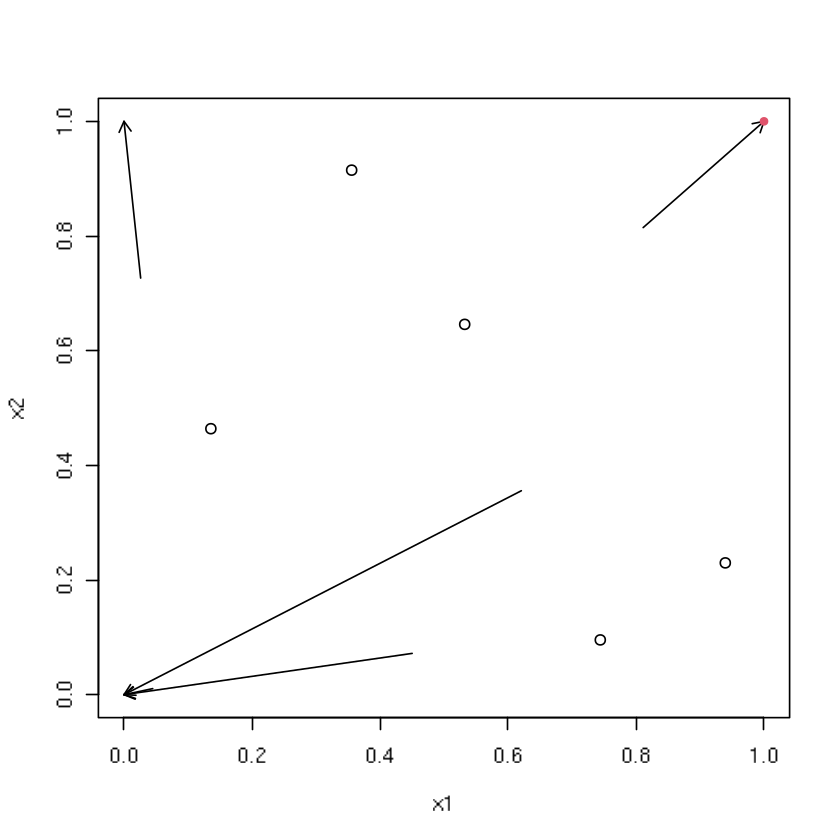

In [212]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(solns$s1, solns$s2, solns$x1, solns$x2, length=0.1)
m <- which.max(solns$val)
prog <- solns$val[m]
points(solns$x1[m], solns$x2[m], col=2, pch=20)

In [213]:
xnew <- as.matrix(solns[m, 3:4])
X <- rbind(X, xnew)
y <- c(y, f(xnew))
X

,x1,x2
,0.1357280,0.46387586
,0.7442083,0.09549342
,0.3557251,0.91485674
,0.9395321,0.22985123
,0.5323460,0.64588793
4,1.0000000,1.00000000


In [214]:
updateGP(gpi, xnew, y[length(y)])
mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
  d$ab, g$ab))
rmse <- c(rmse, sqrt(mean((yytrue - predGP(gpi, XX, lite=TRUE)$mean)^2)))

In [215]:
solns <- xnp1.search(X, gpi)
m <- which.max(solns$val)
prog <- c(prog, solns$val[m])
xnew <- as.matrix(solns[m, 3:4])
X <- rbind(X, xnew)
y <- c(y, f(xnew))
updateGP(gpi, xnew, y[length(y)])
mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
  d$ab, g$ab))
p <- predGP(gpi, XX, lite=TRUE)
rmse <- c(rmse, sqrt(mean((yytrue - p$mean)^2)))


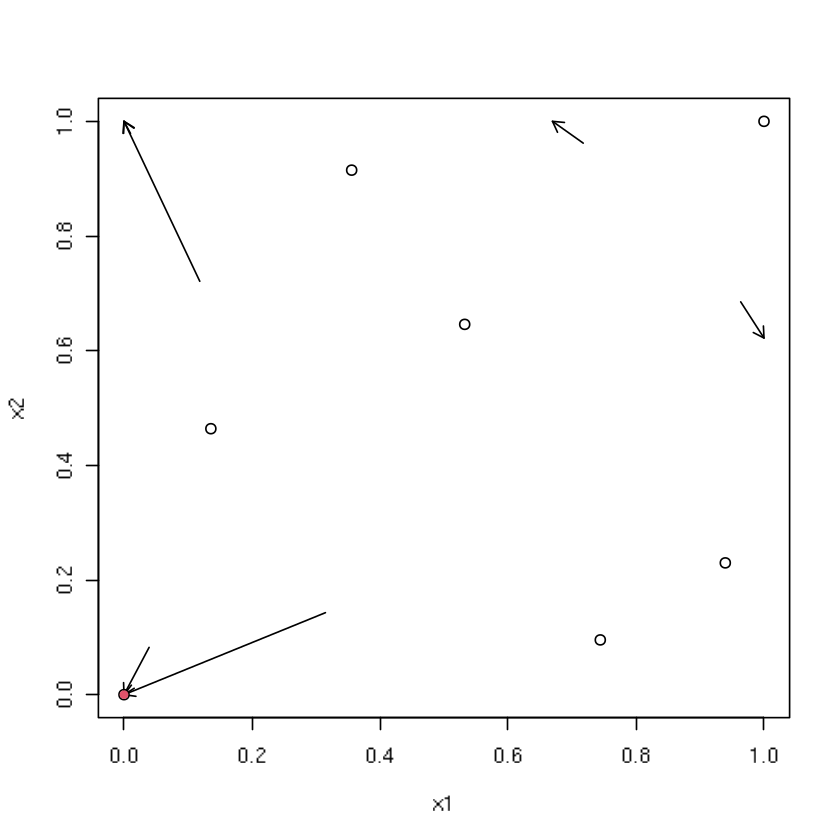

In [216]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(solns$s1, solns$s2, solns$x1, solns$x2, length=0.1)
m <- which.max(solns$val)
points(solns$x1[m], solns$x2[m], col=2, pch=20)

In [217]:
for(i in nrow(X):24) {
  solns <- xnp1.search(X, gpi)
  m <- which.max(solns$val)
  prog <- c(prog, solns$val[m])
  xnew <- as.matrix(solns[m, 3:4])
  X <- rbind(X, xnew)
  y <- c(y, f(xnew))
  updateGP(gpi, xnew, y[length(y)])
  mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
    d$ab, g$ab))
  p <- predGP(gpi, XX, lite=TRUE)
  rmse <- c(rmse, sqrt(mean((yytrue - p$mean)^2)))
}

In [218]:
mle[seq(1,nrow(mle),by=2),]

,d,g,tot.its,dits,gits
,<dbl>,<dbl>,<int>,<int>,<int>
1,0.13193431,0.0006971513,12,6,6
3,0.10343460,0.0006974608,8,5,3
5,0.12292687,0.0006970153,7,4,3
7,0.09712384,0.0006973977,7,4,3
9,0.03492363,0.0006979834,5,3,2
11,0.02990297,0.0006979468,6,4,2
13,0.03070238,0.0006979132,6,4,2
15,0.02810169,0.0006981795,18,15,3
17,0.02810169,0.0006979738,4,2,2


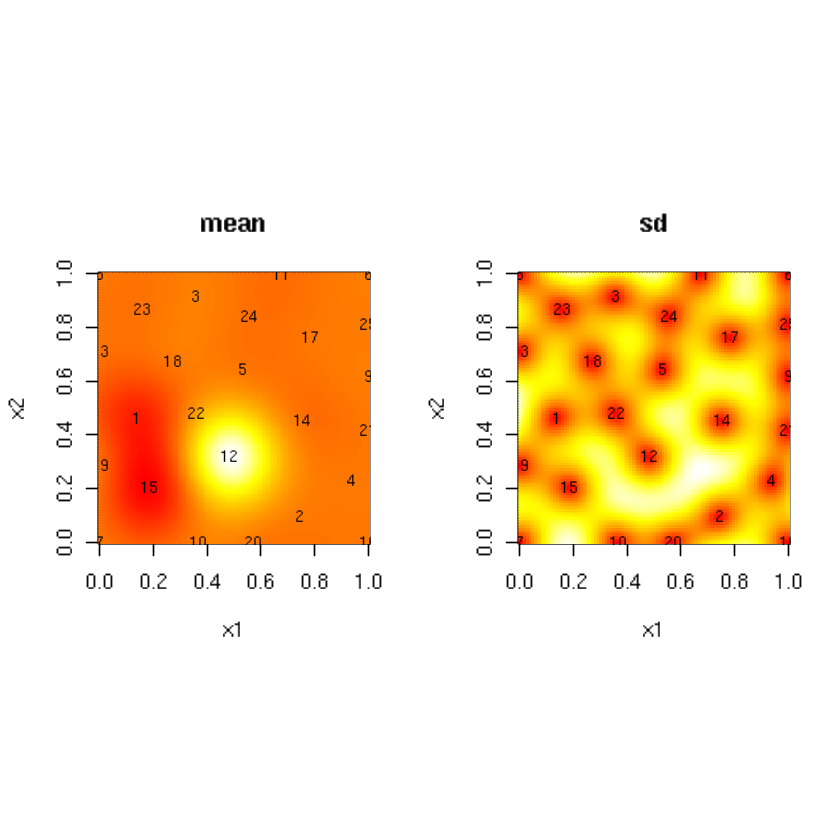

In [219]:
par(mfrow=c(1,2), pty="s")
cols <- heat.colors(128)
image(x1, x2, matrix(p$mean, ncol=length(x1)), col=cols, main="mean")
text(X, labels=1:nrow(X), cex=0.75)
image(x1, x2, matrix(sqrt(p$s2), ncol=length(x1)), col=cols, main="sd")
text(X, labels=1:nrow(X), cex=0.75)

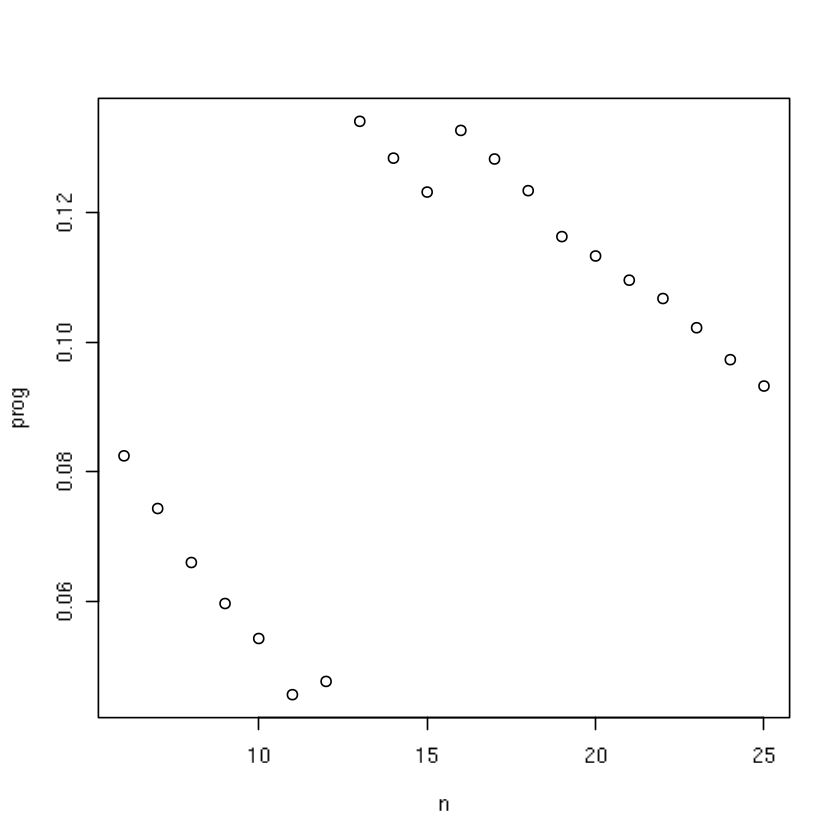

In [220]:
plot((ninit+1):nrow(X), prog, xlab="n")

In [221]:
d <- darg(list(mle=TRUE), X)
for(i in nrow(X):99) {
  solns <- xnp1.search(X, gpi)
  m <- which.max(solns$val)
  prog <- c(prog, solns$val[m])
  xnew <- as.matrix(solns[m, 3:4])
  X <- rbind(X, xnew)
  y <- c(y, f(xnew))
  updateGP(gpi, xnew, y[length(y)])
  mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
    d$ab, g$ab))
  p <- predGP(gpi, XX, lite=TRUE)
  rmse <- c(rmse, sqrt(mean((yytrue - p$mean)^2)))
}

In [222]:
mle[seq(14,nrow(mle), by=10),]

,d,g,tot.its,dits,gits
,<dbl>,<dbl>,<int>,<int>,<int>
14,0.03121319,0.0006978951,6,4,2
24,0.02929814,0.0006976050,7,4,3
34,0.02231393,0.0006972798,7,4,3
44,0.02878178,0.0006897459,7,4,3
54,0.03452270,0.0006595374,8,4,4
64,0.03395488,0.0006654603,11,6,5
74,0.03216136,0.0006584231,11,5,6
84,0.03200882,0.0007702249,19,10,9
94,0.03160907,0.0011324709,34,16,18


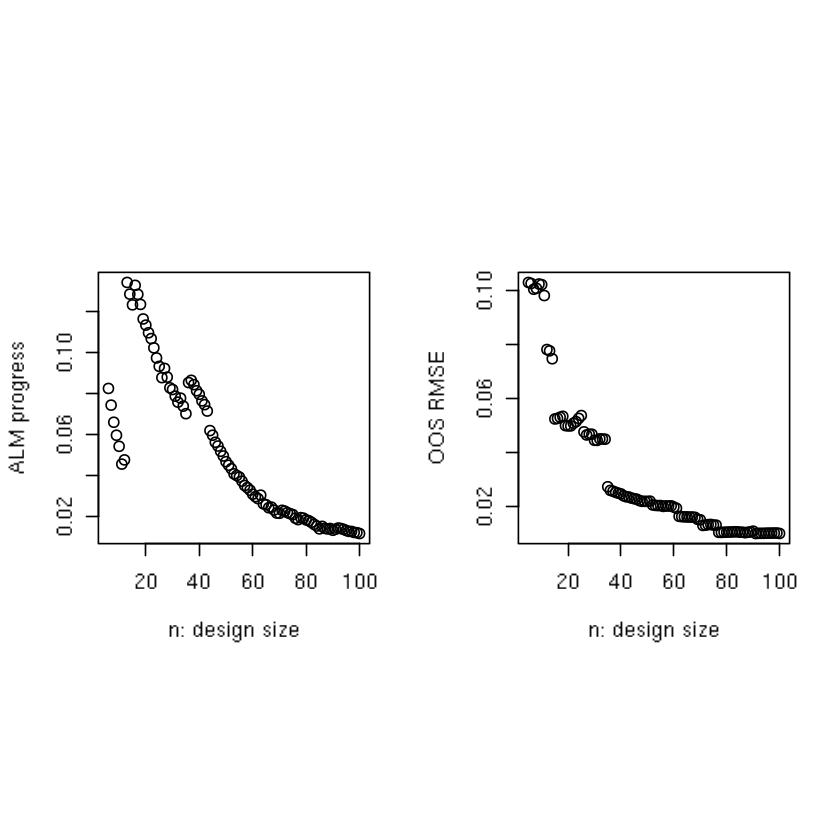

In [223]:
par(mfrow=c(1,2), pty="s")
plot((ninit+1):nrow(X), prog, xlab="n: design size", ylab="ALM progress")
plot(ninit:nrow(X), rmse, xlab="n: design size", ylab="OOS RMSE")

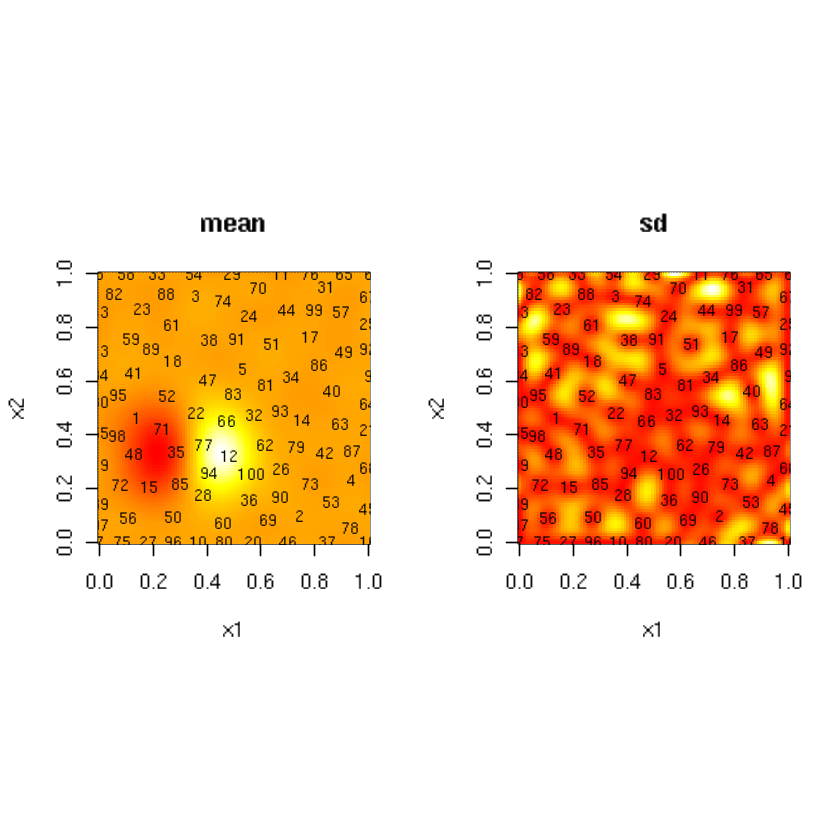

In [224]:
par(mfrow=c(1,2), pty="s")
image(x1, x2, matrix(p$mean, ncol=length(x1)), col=cols, main="mean")
text(X, labels=1:nrow(X), cex=0.75)
image(x1, x2, matrix(sqrt(p$s2), ncol=length(x1)), col=cols, main="sd")
text(X, labels=1:nrow(X), cex=0.75)

### 6.2.2 A More aggregate criteria: active learning Cohn

In [225]:
obj.alc <- function(x, gpi, Xref) 
  - sqrt(alcGP(gpi, matrix(x, nrow=1), Xref))

In [226]:
deleteGP(gpi)
X <- X[1:ninit,]
y <- y[1:ninit]
g <- garg(list(mle=TRUE, max=1), y)
d <- darg(list(mle=TRUE, max=0.25), X)
gpi <- newGP(X, y, d=d$start, g=g$start, dK=TRUE)
mle <- jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), d$ab, g$ab)
p <- predGP(gpi, XX, lite=TRUE)
rmse.alc <- sqrt(mean((yytrue - p$mean)^2))

In [227]:
Xref <- randomLHS(100, 2)
solns <- xnp1.search(X, gpi, obj=obj.alc, Xref=Xref)
m <- which.max(solns$val)
xnew <- as.matrix(solns[m, 3:4])
prog.alc <- solns$val[m]

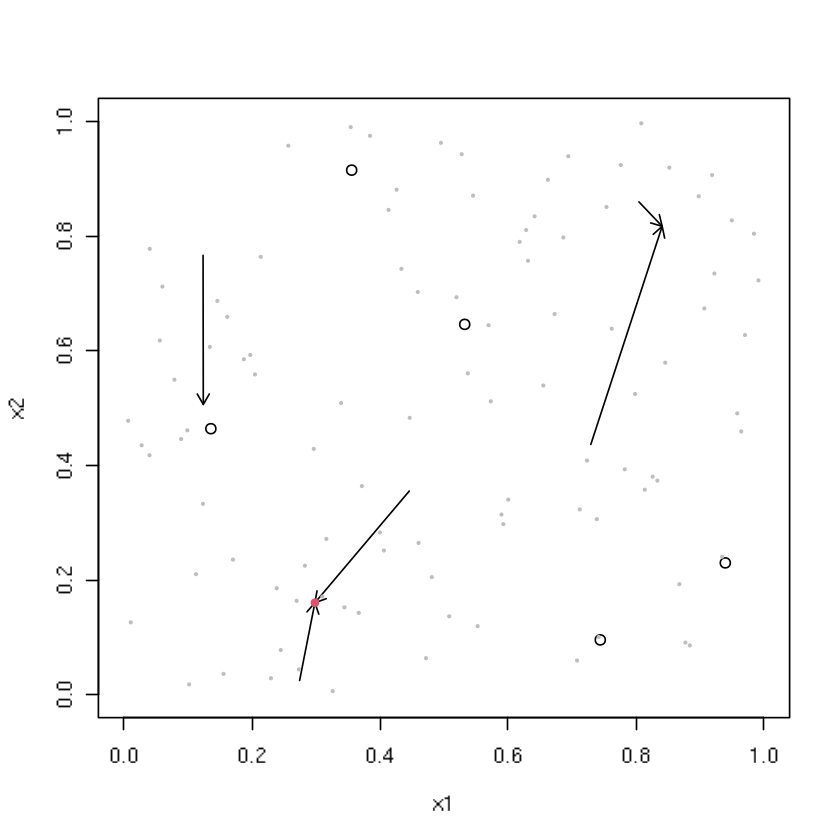

In [228]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(solns$s1, solns$s2, solns$x1, solns$x2, length=0.1)
points(solns$x1[m], solns$x2[m], col=2, pch=20)
points(Xref, cex=0.25, pch=20, col="gray")

In [229]:
X <- rbind(X, xnew)
y <- c(y, f(xnew))
updateGP(gpi, xnew, y[length(y)])
mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
  d$ab, g$ab))
p <- predGP(gpi, XX, lite=TRUE)
rmse.alc <- c(rmse.alc, sqrt(mean((yytrue - p$mean)^2)))

In [230]:
d <- darg(list(mle=TRUE), X)
for(i in nrow(X):99) {
  Xref <- randomLHS(100, 2)
  solns <- xnp1.search(X, gpi, obj=obj.alc, Xref=Xref)
  m <- which.max(solns$val)
  prog.alc <- c(prog.alc, solns$val[m])
  xnew <- as.matrix(solns[m, 3:4])
  X <- rbind(X, xnew)
  y <- c(y, f(xnew))
  updateGP(gpi, xnew, y[length(y)])
  mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
    d$ab, g$ab))
  p <- predGP(gpi, XX, lite=TRUE)
  rmse.alc <- c(rmse.alc, sqrt(mean((yytrue - p$mean)^2)))
}

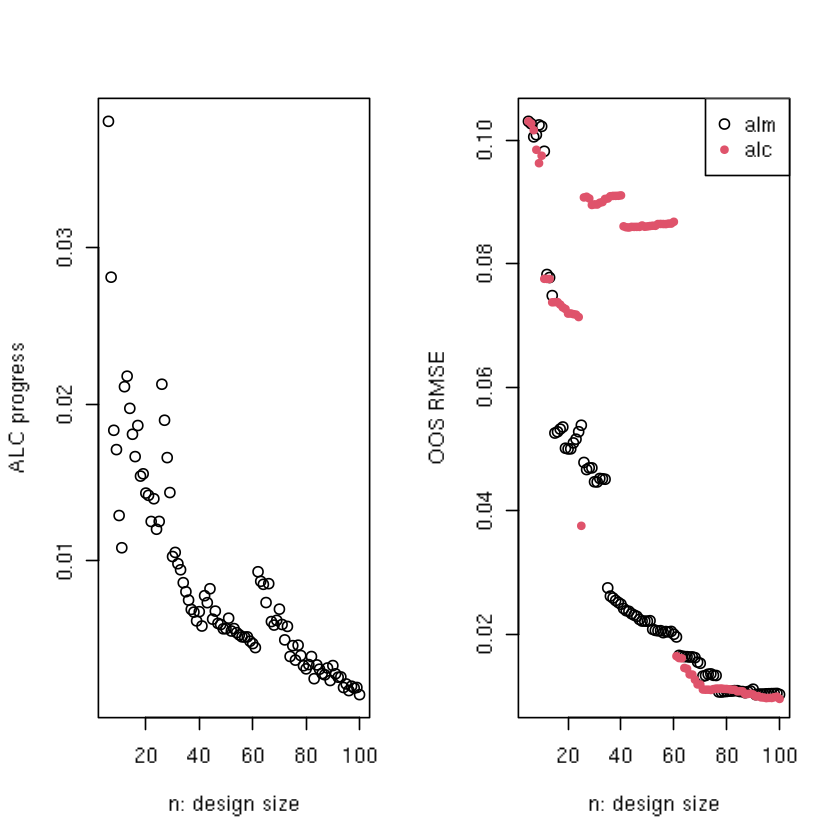

In [231]:
par(mfrow=c(1,2))
plot((ninit+1):nrow(X), prog.alc, xlab="n: design size", 
  ylab="ALC progress")
plot(ninit:nrow(X), rmse, xlab="n: design size", ylab="OOS RMSE")
points(ninit:nrow(X), rmse.alc, col=2, pch=20)
legend("topright", c("alm", "alc"), pch=c(21,20), col=1:2)


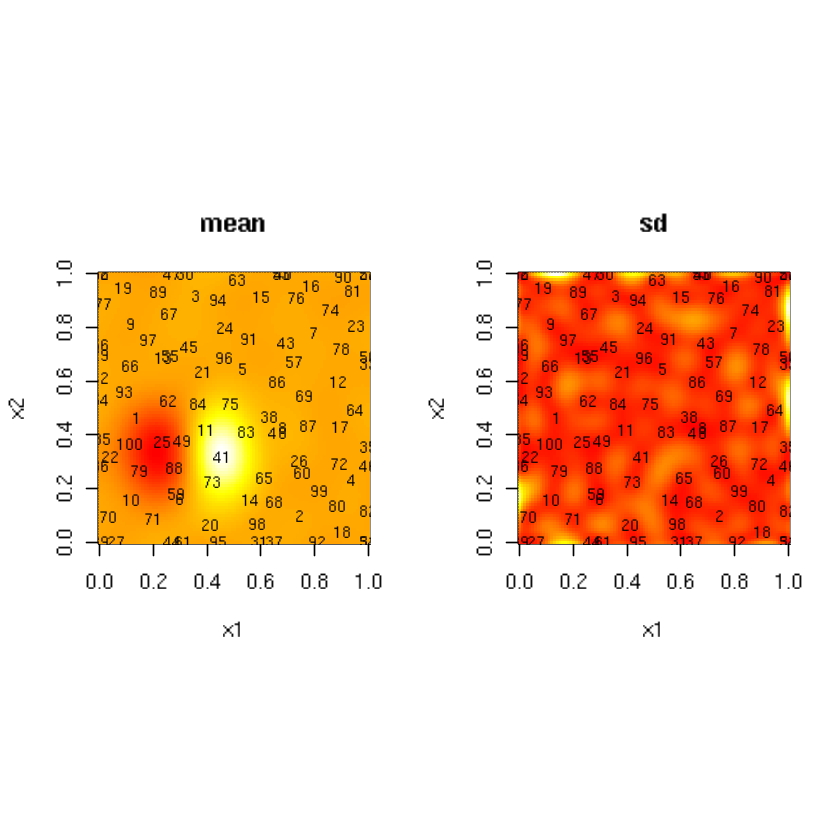

In [234]:
par(mfrow=c(1,2), pty="s")
image(x1, x2, matrix(p$mean, ncol=length(x1)), col=cols, main="mean")
text(X, labels=1:nrow(X), cex=0.75)
image(x1, x2, matrix(sqrt(p$s2), ncol=length(x1)), col=cols, main="sd")
text(X, labels=1:nrow(X), cex=0.75)


### 6.2.3 Other sequential criteria

In [233]:
obj.fish <- function(x, gpi) 
  - sqrt(fishGP(gpi, matrix(x, nrow=1)))

In [235]:
X <- X[1:ninit,]
y <- y[1:ninit]
d <- darg(list(mle=TRUE, max=0.25), X)
gpi <- newGP(X, y, d=0.1, g=0.1*var(y), dK=TRUE)
mle <- jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), d$ab, g$ab)
rmse.fish <- sqrt(mean((yytrue - predGP(gpi, XX, lite=TRUE)$mean)^2))
prog.fish <- c()
for(i in nrow(X):99) {
  solns <- xnp1.search(X, gpi, obj=obj.fish)
  m <- which.max(solns$val)
  prog.fish <- c(prog.fish, solns$val[m])
  xnew <- as.matrix(solns[m, 3:4])
  X <- rbind(X, xnew)
  y <- c(y, f(xnew))
  updateGP(gpi, xnew, y[length(y)])
  mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
    d$ab, g$ab))
  p <-predGP(gpi, XX, lite=TRUE)
  rmse.fish <- c(rmse.fish, sqrt(mean((yytrue - p$mean)^2)))
}

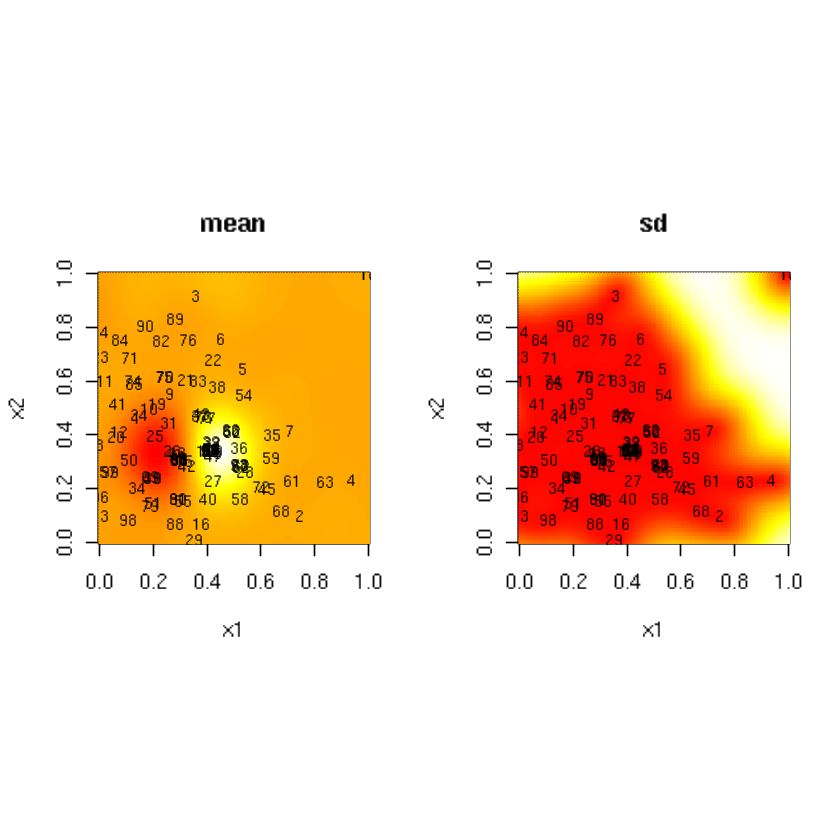

In [236]:
par(mfrow=c(1,2), pty="s")
image(x1, x2, matrix(p$mean, ncol=length(x1)), col=cols, main="mean")
text(X, labels=1:nrow(X), cex=0.75)
image(x1, x2, matrix(sqrt(p$s2), ncol=length(x1)), col=cols, main="sd")
text(X, labels=1:nrow(X), cex=0.75)


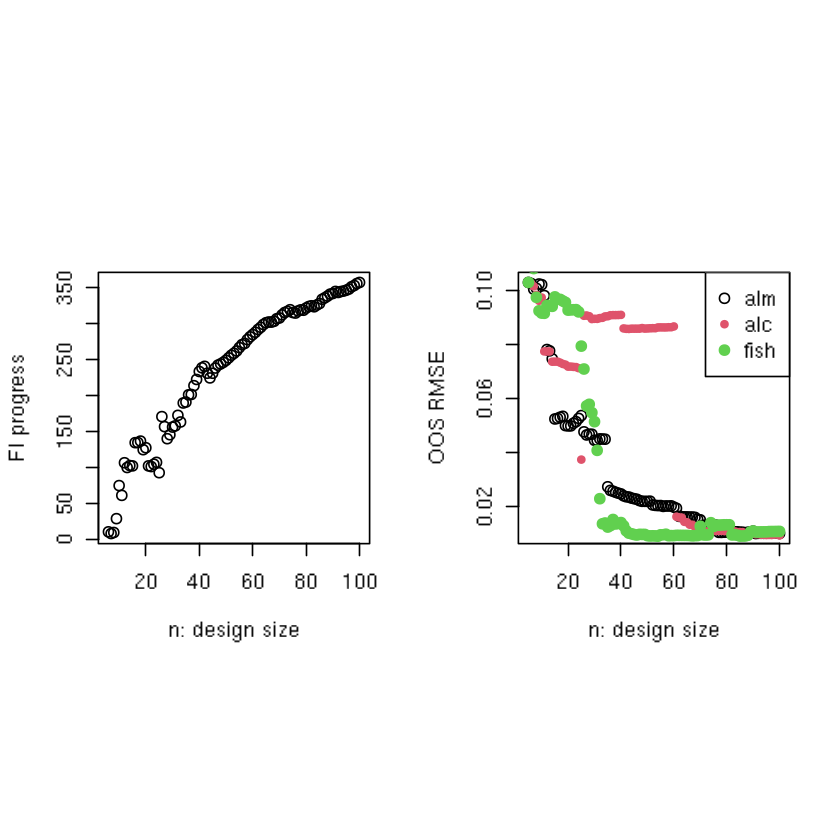

In [237]:
par(mfrow=c(1,2), pty="s")
plot((ninit+1):nrow(X), prog.fish, xlab="n: design size", 
  ylab="FI progress") 
plot(ninit:nrow(X), rmse, xlab="n: design size", ylab="OOS RMSE")
points(ninit:nrow(X), rmse.alc, col=2, pch=20)
points(ninit:nrow(X), rmse.fish, col=3, pch=19)
legend("topright", c("alm", "alc", "fish"), pch=21:19, col=1:3)